In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Correct path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/kvasir8K.zip'

# Destination path where you want to unzip the file
dest_path = '/content/Kvasir_folder8k'

# Create destination directory if it doesn't exist
os.makedirs(dest_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

print("Unzipping completed!")

Unzipping completed!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, callbacks
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt


#from tensorflow.keras import layers, models, optimizers, callbacks

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 227
CHANNELS=3
EPOCHS= 60
n_classes = 8

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Kvasir_folder8k/kvasir-dataset-v2",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8000 files belonging to 8 classes.


**Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds)

200

In [ ]:
def create_alexnet(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        resize_and_rescale,
        data_augmentation,

        layers.Conv2D(96, (11, 11), strides=4, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Flatten(),

        layers.Dense(4096, activation='relu',),
        layers.Dropout(0.4),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
alexnet_model = create_alexnet((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes)

In [ ]:
alexnet_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │          32,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,315,528 (222.46 MB)

 Trainable params: 58,314,824 (222.45 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
alexnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
history = alexnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 301ms/step - accuracy: 0.4622 - loss: 1.4138 - val_accuracy: 0.1175 - val_loss: 6.7848 - learning_rate: 1.0000e-04
Epoch 2/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.6375 - loss: 0.8020 - val_accuracy: 0.3762 - val_loss: 2.3732 - learning_rate: 1.0000e-04
Epoch 3/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.6889 - loss: 0.6976 - val_accuracy: 0.5750 - val_loss: 1.0206 - learning_rate: 1.0000e-04
Epoch 4/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - accuracy: 0.6956 - loss: 0.6743 - val_accuracy: 0.3187 - val_loss: 2.6344 - learning_rate: 1.0000e-04
Epoch 5/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.7016 - loss: 0.6538 - val_accuracy: 0.6587 - val_loss: 0.8229 - learning_rate: 1.0000e-04
Epoch 6/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 237ms/step - accuracy: 0.7286 - loss: 0.6155 - val_accuracy: 0.7262 - val_loss: 0.5880 - learning_rate: 1.0000e-04
Epoch 7/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 23

In [ ]:

class_names = dataset.class_names
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [ ]:
del(train_ds)
del(val_ds)

In [ ]:
# Evaluate the model
scores = alexnet_model.evaluate(test_ds)


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9089 - loss: 0.2297


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

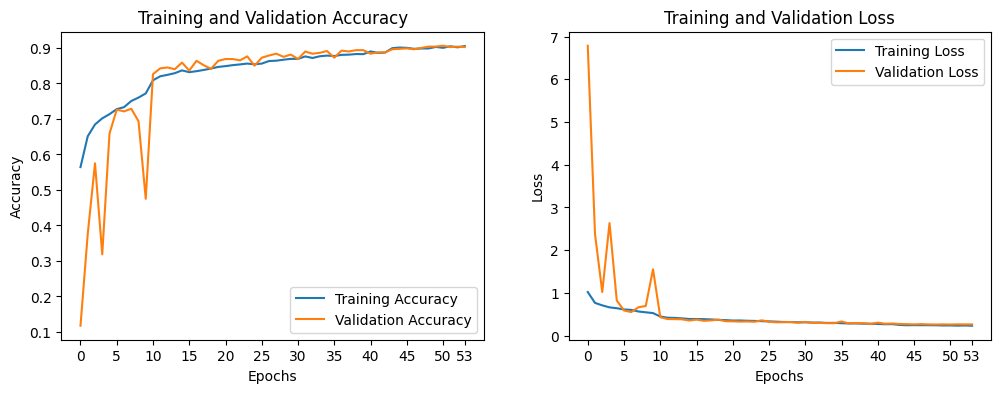

In [ ]:
# Use the length of the actual data (acc and val_acc arrays) for the x-axis
epochs_range = range(len(acc))  # or len(val_acc), they should have the same length

plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(ticks=list(range(0, len(acc), 5)) + [len(acc)-1])  # Add the last epoch to x-axis ticks

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(ticks=list(range(0, len(loss), 5)) + [len(loss)-1])  # Add the last epoch to x-axis ticks

plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


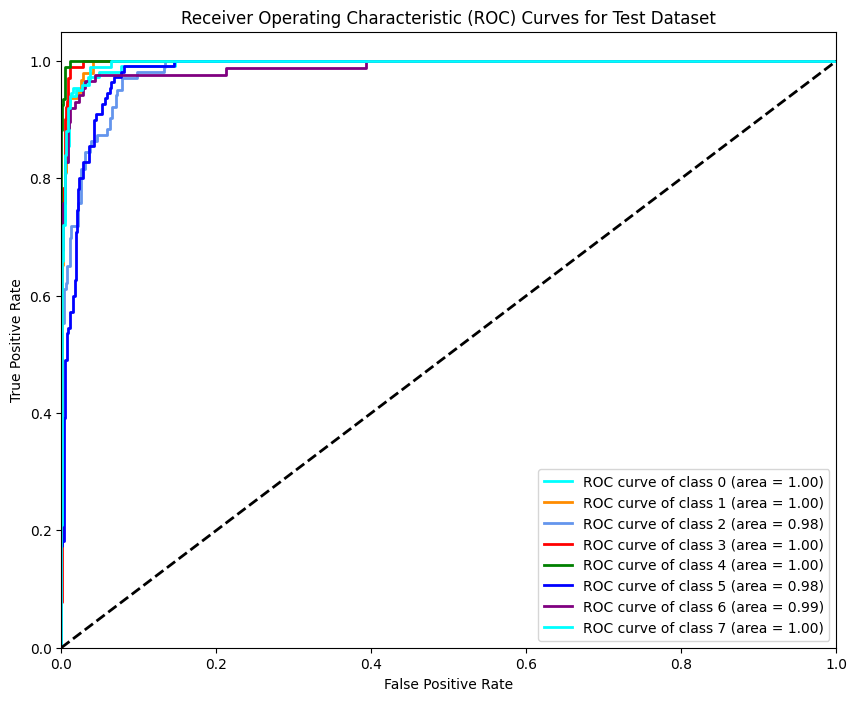

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from itertools import cycle
import tensorflow as tf

# Assuming test_ds, googlenet_model, and class_names are already defined
n_classes = len(class_names)

# Accumulate all batches into numpy arrays
all_images = []
all_labels = []

for images_batch, labels_batch in test_ds:
    all_images.append(images_batch.numpy())
    all_labels.append(labels_batch.numpy())

# Convert lists to numpy arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Get model predictions
test_predictions = alexnet_model.predict(all_images)

# One-hot encode the labels if they are not already
if all_labels.ndim == 1 or all_labels.shape[1] != n_classes:
    all_labels = tf.keras.utils.to_categorical(all_labels, num_classes=n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), test_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Test Dataset')
plt.legend(loc="lower right")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 1000x800 with 0 Axes>

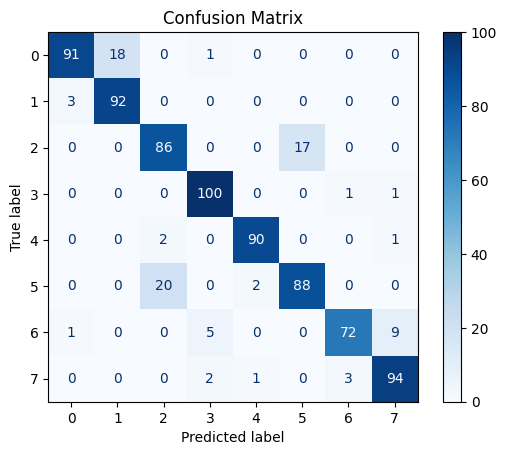

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       110
           1       0.84      0.97      0.90        95
           2       0.80      0.83      0.82       103
           3       0.93      0.98      0.95       102
           4       0.97      0.97      0.97        93
           5       0.84      0.80      0.82       110
           6       0.95      0.83      0.88        87
           7       0.90      0.94      0.92       100

    accuracy                           0.89       800
   macro avg       0.90      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



all_true_labels = []
all_predicted_labels = []

for images_batch, labels_batch in test_ds:
    # Get true labels
    true_labels = labels_batch.numpy()
    all_true_labels.extend(true_labels)

    # Get predicted labels
    batch_predictions = alexnet_model.predict(images_batch)
    predicted_labels = np.argmax(batch_predictions, axis=1)
    all_predicted_labels.extend(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=np.arange(8))  # Use np.arange(8) to display 0 to 7

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(all_true_labels, all_predicted_labels, target_names=[str(i) for i in range(8)])
print("Classification Report:\n", report)

In [ ]:
alexnet_model.save('/content/drive/My Drive/alexnet_model90.h5')


TypeError: cannot pickle 'module' object

In [ ]:
pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
